## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
from keras.regularizers import l1,l2,l1_l2
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

%matplotlib inline


# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256], l1_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
monitor = ['val_loss', 'val_acc']

results = {}
for m in monitor:
    earlystop = EarlyStopping(monitor= m, 
                              patience=5, 
                              verbose=1
                              )

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop])

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']

    results[m] = {'train_loss': train_loss,
                  'valid_loss': valid_loss,
                  'train_acc': train_acc,
                  'valid_acc': valid_acc}





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 1,707,274

Epoch 27/50
50000/50000 [==============================] - 95s 2ms/step - loss: 1.7179 - acc: 0.4738 - val_loss: 1.6960 - val_acc: 0.4802
Epoch 28/50
50000/50000 [==============================] - 95s 2ms/step - loss: 1.7092 - acc: 0.4798 - val_loss: 1.6361 - val_acc: 0.5086
Epoch 29/50
50000/50000 [==============================] - 97s 2ms/step - loss: 1.7036 - acc: 0.4790 - val_loss: 1.6506 - val_acc: 0.4980
Epoch 30/50
50000/50000 [==============================] - 97s 2ms/step - loss: 1.7097 - acc: 0.4761 - val_loss: 1.6583 - val_acc: 0.4966
Epoch 31/50
50000/50000 [==============================] - 99s 2ms/step - loss: 1.6920 - acc: 0.4823 - val_loss: 1.6457 - val_acc: 0.5051
Epoch 32/50
50000/50000 [==============================] - 97s 2ms/step - loss: 1.6947 - acc: 0.4815 - val_loss: 1.6591 - val_acc: 0.4971
Epoch 33/50
50000/50000 [==============================] - 98s 2ms/step - loss: 1.6875 - acc: 0.4846 - val_loss: 1.6782 - val_acc: 0.4930
Epoch 00033: early stopping
______

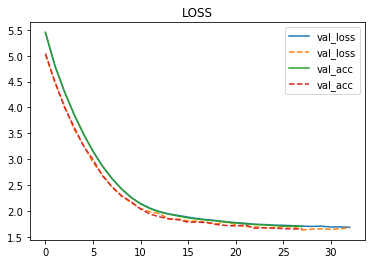

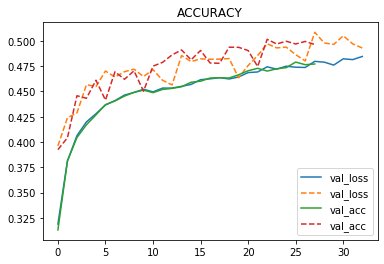

In [8]:
for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()

In [9]:
# 載入 Callbacks
patience = [10, 25]

results = {}
for p in patience:
    earlystop = EarlyStopping(monitor= 'val_loss', 
                              patience=p, 
                              verbose=1
                              )

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop])

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']

    results[str(p)] = {'train_loss': train_loss,
                  'valid_loss': valid_loss,
                  'train_acc': train_acc,
                  'valid_acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 97s 2ms/step - loss: 5.4451 - acc: 0.3140 - val_loss: 5.0184 - val_acc: 0.3850
Epoch 2/50
50000/50000 [==============================] - 95s 2ms/step - loss: 4.8069 - acc: 0.3785 - val_loss: 4.4816 - val_acc: 0.4218
Epoch 3/50
50000/50000 [==============================] - 96s 2ms/step - loss: 4.3053 - acc: 0.4025 - val_loss: 4.0651 - val_acc: 0.4122
Epoch 4/50
50000/50000 [==============================] - 99s 2ms/step - loss: 3.8703 - acc: 0.4206 - val_loss: 3.6187 - val_acc: 0.4520
Epoch 5/50
50000/50000 [==============================] - 91s 2ms/step - loss: 3.4921 - acc: 0.4304 - val_loss: 3.2609 - val_acc: 0.4478
Epoch 6/50
50000/50000 [==============================] - 91s 2ms/step - loss: 3.1533 - acc: 0.4372 - val_loss: 2.9546 - val_acc: 0.4610
Epoch 7/50
50000/50000 [==============================] - 91s 2ms/step - loss: 2.8676 - acc: 0.4422 - val_loss: 2.6780 - val_acc

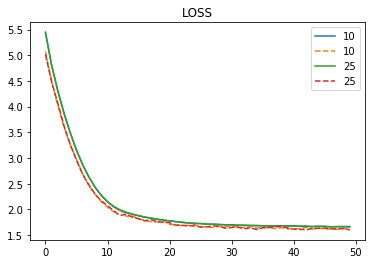

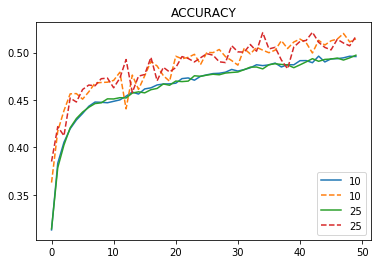

In [10]:
for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()